In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px


# load data:
file_path = "hotel_bookings_rich.csv"
full_data = pd.read_csv(file_path)


# Case 3: Data-driven approaches for revenue management

You are expected to contribute to the topic from three perspectives bringing together insights from the course material on optimization and data analysis.



## Question 1 - Static Policies

### a) Protection levels
We discussed protection levels as a means to trade off base utilization from low cost bookings against flexible bookings by high value customers. We want to explore this practice in the data by doing the following:

* We limit the analysis on the city hotel and only consider bookings that took place, had two adults, meal = BB and took at most 3 nights
* We split the data as follows: all bookings with lead time less than 2 weeks are spontaneous (high-value bookings), the remaining are low-value long-term bookings
* Use the average ADR for the two segments as the value

Our dataset features bookings over the course of 2 years. How can you come up with the nightly arrival rate of the spotaneous bookings as defined above?

Assume a poisson distribution and execute the protection level analysis as in the lecture assuming a hotel size of 30.


In [3]:
city_hotel_slice = full_data[(full_data["is_canceled"] == 0) & (full_data["hotel"] == "City Hotel") & (full_data["adults"] == 2) & (full_data["meal"] == "BB")]
city_hotel_slice

city_hotel_slice["booking_flag"] = city_hotel_slice['lead_time'].apply(lambda x: 'spontaneous' if x < 14 else 'longterm')

city_hotel_slice.groupby(["booking_flag"])["adr"].describe()

/tmp/ipykernel_1125/3488426975.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_hotel_slice["booking_flag"] = city_hotel_slice['lead_time'].apply(lambda x: 'spontaneous' if x < 14 else 'longterm')


,count,mean,std,min,25%,50%,75%,max
booking_flag,,,,,,,,
longterm,18947.0,104.255859,35.281313,0.0,80.0,98.1,123.3,451.50
spontaneous,5161.0,113.395631,48.143876,0.0,86.6,108.0,140.0,333.67


In [4]:
!pip install pulp
import numpy as np
from scipy.stats import poisson
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value

# Parameters
total_rooms = 30
low_fare = 104.25
high_fare = 113.39
mean_demand_high_fare = 5161 / (365*2)

# Poisson probabilities
probabilities = [poisson.pmf(d, mean_demand_high_fare) for d in range(total_rooms + 1)]

# Define the LP problem
problem = LpProblem("Maximize_Expected_Revenue", LpMaximize)

# Decision variables
protect = LpVariable("protect", 0, total_rooms, cat="Continuous")
sales_high = LpVariable.dicts("sales_high", range(total_rooms + 1), 0, total_rooms, cat="Continuous")

# Objective function
revenue_terms = []

for d in range(total_rooms + 1):
    revenue_terms.append(probabilities[d] * (sales_high[d] * high_fare + (total_rooms - protect) * low_fare))

problem += lpSum(revenue_terms), "Expected_Revenue"

# Constraints
for d in range(total_rooms + 1):
    problem += sales_high[d] <= protect, f"High_Fare_Sales_Limit_{d}"
    problem += sales_high[d] <= d, f"Demand_Limit_{d}"

# Solve the problem
problem.solve()

# Extract results
optimal_protected_high_fare_rooms = int(value(protect))
max_revenue = value(problem.objective)

print(f"Optimal number of high fare rooms to protect: {optimal_protected_high_fare_rooms}")
print(f"Maximum expected revenue: ${max_revenue:.2f}")

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/vscode/.local/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/6c3b2ef2b288420296c83ddec4758fa7-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/6c3b2ef2b288420296c83ddec4758fa7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 67 COLUMNS
At line 193 RHS
At line 256 BOUNDS
At line 289 ENDATA
Problem MODEL has 62 rows, 32 columns and 93 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 29 (-33) rows, 30 (-2) columns and 58 (-35) elements
0  Obj -0 Dual inf 113.29355 (26)
23  Obj 23.631078
Optimal - objective value 23.631078
After Postsolve, objective 23.631078, infeasibilities - dua

### b) Overbooking

Allocating more rooms than actually available is a common appraoch to cope with cancellations in the hospitality industry. The model we discussed trades off penalty payments in case of more demand having maternalized vs. extra revenues from overbooked demand. This is a natural for the dataset at hand but we need to be careful which offers access to frequency of cancellations as well as rates. At the same time penalty payments / goodwill remains unsepcified. For this reason we expect you to do the following:

* Establish a meaningful analysis scenario to harmonize the data you calibrate the model on (as we did in question a). You can pick the hotel size as you like.
* Estimate the historical cancellation rate, average ADR and demand level for your scenario.
* Determine the optimal overbooking levels for varying level of goodwill (e.g., ADR * 1.5 through ADR * 3) and visualize the obtained penalty-overbooking relationship.

### c) Bonus Activities

Try to expand the previous analysis to cover richer settings. Idea that you could explore include (but are nor restricted to) the following:

* Accounting for quarterly patterns of ADR and cancellation rates (periodic adjustment of policies)
* Replacing booking class by a an ADR threshold which has to be optimized. Use the data to obtain a distribution of the rates and come up with a meaningful way to incorporate it into the stochastic program scenarios.

## Dynamic Policies

In the lecture we briefly introduced the minimal simulation framework below. Note this is an updated version which also provides the opportunity to run a parameter search across a value. For the case study you are expected to contribute in two ways:

* Create an optimized logic which adapts the protection level dynamically each simulation step. Can you improve the results?
* Integrate cancellations as an additional random arrival and see if you can also include overbooking in the simulation.

You may also consider the following bonus activities:

* Creating a simulation on top a strip of the real data: taking some data for calibration and then use the remaining data to play out the arrival and cancellations of bookings. Again you will have to come up with a meaningful scenario yourself.
* Are you still able to find good dynamic policies? Comment on the difficulties going from the stylized model to the real data.

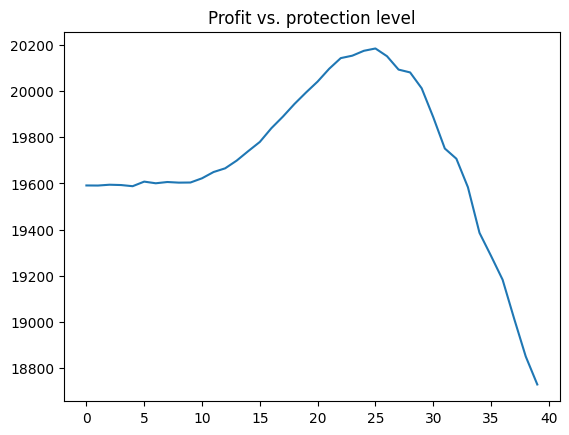

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
total_rooms = 118
low_fare = 159
high_fare = 225
time_horizon = 30  # days booking horizon

mean_demand_high_fare_daily = 27.3 / time_horizon  # Daily mean demand for high fare
mean_demand_low_fare_daily = 118 * 2 / time_horizon  # High probability to exceed 118 over 30 days
num_simulations = 1000  # Number of simulations



def simulate_booking(protection):
    # Static booking limits from earlier calculations
    optimal_high_fare_rooms = protection  # Approximation of earlier result
    optimal_low_fare_rooms = total_rooms - optimal_high_fare_rooms

    high_fare_bookings = np.zeros(time_horizon)
    low_fare_bookings = np.zeros(time_horizon)
    daily_profit = np.zeros(time_horizon)

    cumulative_high_fare_bookings = 0
    cumulative_low_fare_bookings = 0
    cumulative_profit = 0

    for t in range(time_horizon):
        # Simulate arrivals
        high_fare_arrivals = np.random.poisson(mean_demand_high_fare_daily)
        low_fare_arrivals = np.random.poisson(mean_demand_low_fare_daily)

        # Prioritize high fare bookings
        available_rooms = total_rooms - cumulative_high_fare_bookings - cumulative_low_fare_bookings
        bookings_high = min(high_fare_arrivals, available_rooms)
        cumulative_high_fare_bookings += bookings_high

        # Update available rooms after high fare bookings
        available_rooms = min(total_rooms - cumulative_high_fare_bookings - cumulative_low_fare_bookings, optimal_low_fare_rooms-cumulative_low_fare_bookings)
        bookings_low = min(low_fare_arrivals, available_rooms)
        cumulative_low_fare_bookings += bookings_low

        # Calculate daily profit
        profit = bookings_high * high_fare + bookings_low * low_fare
        cumulative_profit += profit

        # Store daily results
        high_fare_bookings[t] = cumulative_high_fare_bookings
        low_fare_bookings[t] = cumulative_low_fare_bookings
        daily_profit[t] = cumulative_profit

    return high_fare_bookings, low_fare_bookings, daily_profit

# Run simulations
results = {}
all_high_fare_bookings = {}
all_low_fare_bookings = {}
all_daily_profits = {}

for protection in range(40):
    all_high_fare_bookings[protection] = []
    all_low_fare_bookings[protection] = []
    all_daily_profits[protection] = []
    for _ in range(num_simulations):
        high_fare_bookings, low_fare_bookings, daily_profit = simulate_booking(protection)
        all_high_fare_bookings[protection].append(high_fare_bookings)
        all_low_fare_bookings[protection].append(low_fare_bookings)
        all_daily_profits[protection].append(daily_profit)
    profit = sum([all_daily_profits[protection][i][-1] for i in range(num_simulations)])/num_simulations
    results[protection] = profit



myList = sorted(results.items())
x, y = zip(*myList)

plt.plot(x, y)
plt.title('Profit vs. protection level')
plt.show()

## Prescriptive Analytics

We now want to combine the predictive model obtained from applying machine learning on the data with a stochastic overbooking program.

Setup, data inspection and cleanup are hidden for easier reading. Click the Code/Output buttons if you are curious.

In [1]:
# common:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

# for ML:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score



# set some display options:
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 36)

# load data:
file_path = "hotel_bookings.csv"
full_data = pd.read_csv(file_path)

# Replace missing values:
# agent: If no agency is given, booking was most likely made without one.
# company: If none given, it was most likely private.
# rest schould be self-explanatory.
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
full_data_cln = full_data.fillna(nan_replacements)

# "meal" contains values "Undefined", which is equal to SC.
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entreis with 0 adults, 0 children and 0 babies. 
# We are dropping these entries with no guests.
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

full_data_cln.shape

rh = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"] == 0)]
ch = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"] == 0)]

## 1. Predict cancelations  

Which numerical features are most important? 

In [2]:
cancel_corr = full_data.corr(numeric_only = True)["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

In [3]:
cancel_corr = full_data.corr(numeric_only = True)["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

From this list it is apparent that lead_time, total_of_special_requests, required_car_parking_spaces, booking_changes and previous_cancellations are the 5 most important numerical features.  
However, to predict wheater or not a booking will be canceled, the number of booking changes is a possible source of leakage, because this information can change over time.  
I will also not include days_in_waiting_list and arrival_date_year.  
  
The most important feature to exclude is the "reservation_status":

In [4]:
full_data.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
Name: count, dtype: int64

### Comparing different base models:

In [21]:
# manually choose columns to include
# some columns are excluded to make the model more general and to prevent leakage
# (arrival_date_year, assigned_room_type, booking_changes, reservation_status, country,
# days_in_waiting_list)
# including the country would increase accuracy, but it may also make the model less general

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features
X = full_data.drop(["is_canceled"], axis=1)[features]
y = full_data["is_canceled"]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

In [26]:
# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # get cross validation score for each model:
    cv_results = cross_val_score(model_steps, 
                                 X_train, y_train, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")
    
    model_steps.fit(X_train, y_train)
    preds = model_steps.predict(X_test)
    score = accuracy_score(y_test, preds)
    print(f"{name} accuracy_score: {round(score, 4)}")
    

DT_model cross validation accuarcy score: 0.8182 +/- 0.0019 (std) min: 0.8159, max: 0.8206
DT_model accuracy_score: 0.8265
RF_model cross validation accuarcy score: 0.8617 +/- 0.0012 (std) min: 0.8596, max: 0.8629
RF_model accuracy_score: 0.8697


/home/vscode/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vscode/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

LR_model cross validation accuarcy score: 0.7952 +/- 0.0027 (std) min: 0.7909, max: 0.7979


/home/vscode/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR_model accuracy_score: 0.794
XGB_model cross validation accuarcy score: 0.846 +/- 0.0018 (std) min: 0.8437, max: 0.8484
XGB_model accuracy_score: 0.8452


In [50]:
predictor = Pipeline(steps=[('preprocessor', preprocessor),
                              base_models[1][1]])

In [53]:
[item[0] fir    °predictor.predict_proba(X_test)

array([[1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       ...,
       [0.83333333, 0.16666667],
       [1.        , 0.        ],
       [0.        , 1.        ]])

ValueError: x and y must be the same size

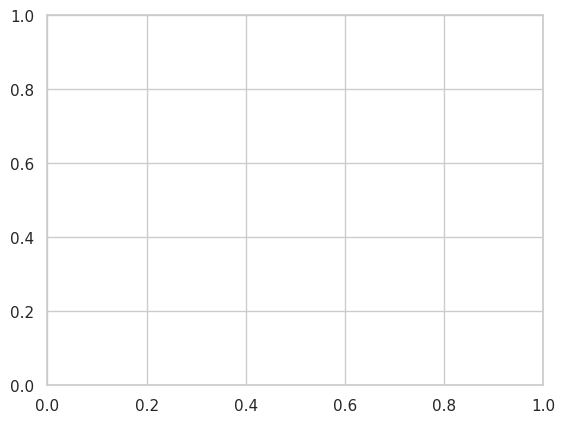

In [54]:
plt.scatter(y_test, predictor.predict_proba(X_test))